In [1]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguedashlineups
from nba_api.stats.endpoints import leaguedashplayerstats
from nba_api.stats.endpoints import teamdashlineups
from nba_api.stats.endpoints import leaguegamelog
from nba_api.stats.endpoints import commonteamroster
from nba_api.stats.endpoints import leaguestandings
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
import time

In [2]:
def LineupData(season,per):
    tempdf1 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Base', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf2 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Advanced',
                                                  season = season, 
                                                  per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf3 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Four Factors', 
                                                  season = season,
                                                  per_mode_detailed = per).get_data_frames()[0]
    tempdf4 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Misc',
                                                  season = season, 
                                                  per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf5 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Scoring', 
                                                  season = season, 
                                                  per_mode_detailed = per).get_data_frames()[0]
    tempdf6 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Opponent',
                                                  season = season,
                                                  per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    
    tempdf = pd.merge(tempdf1,tempdf2, on= 'GROUP_ID', how='outer',suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf3, on= 'GROUP_ID', how='outer',suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf4, on= 'GROUP_ID', how='outer',suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf5, on= 'GROUP_ID', how='outer',suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf6, on= 'GROUP_ID', how='outer',suffixes = ('','_y'))
    
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('RANK')]]
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('_y')]]
    
    tempdf1 = tempdf[['GROUP_ID','PLUS_MINUS']].copy()
    
    print("done")
    return(tempdf1)

In [3]:
def LineupData1(season,per):
    tempdf = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Base', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    
    tempdf1 = tempdf[['GROUP_ID','GP','PLUS_MINUS']].copy()
    
    print("done")
    return(tempdf1)

In [4]:
def PlayerData(season,per):
    tempdf1 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Base', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf2 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Advanced', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf3 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Usage', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf4 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Misc', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf5 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Scoring', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf6 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Defense', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    
    tempdf = pd.merge(tempdf1,tempdf2, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf3, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf4, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf5, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf6, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('RANK')]]
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('_y')]]
    
    print('done')
    return(tempdf)

In [5]:
#Returns dictionary of scores
def nMax(n,playerids,attributes):
    teamscore = 0
    #Loop through players in lineup
    teamAttr = defaultdict(list)
    for player in playerids:
        playerstats = dfPlayer.loc[dfPlayer['PLAYER_ID'] == int(player)]
            
        for attr in attributes:
            playerscore = playerstats.iloc[0][attr]
            teamAttr[attr].append(playerscore)

    rawAttr = defaultdict()
    for x in teamAttr:
        teamAttr[x].sort(reverse = True)
        teamAttr[x] = teamAttr[x][:n]
        rawAttr[x] = sum(teamAttr[x][:n])
    return(rawAttr)

In [31]:
def Train(df,attributes):
    for index, row in df.iterrows():
        playerids = row['GROUP_ID'].split("-")[1:-1]
        
        info = nMax(2,playerids,attributes)

        for key,value in info.items():
            df.at[index,key] = value
            
    return(df)

In [32]:
def ScoreCalc(df,attributes):
    df1 = Train(df,attributes)
    df1 = df1.loc[(df1['GP'] >= 10)]
    
    coeff = {}
    for attr in attributes:
        model = sm.OLS(df1['PLUS_MINUS'],df1[attr]).fit()
        val = model.tvalues[0] 
        coeff[attr] = val
    
    #calculate the scores
    df1['Score'] = (coeff[attributes[0]]*df1[attributes[0]] + coeff[attributes[1]]*df1[attributes[1]] + 
        coeff[attributes[2]]*df1[attributes[2]] + coeff[attributes[3]]*df1[attributes[3]] + 
        coeff[attributes[4]]*df1[attributes[4]] + coeff[attributes[5]]*df1[attributes[5]] + 
        coeff[attributes[6]]*df1[attributes[6]] + coeff[attributes[7]]*df1[attributes[7]])
    
#     df1['score'] = df1.apply(lambda x: coeff[attributes[0]]*df1[attributes[0]] + coeff[attributes[1]]*df1[attributes[1]] + 
#         coeff[attributes[2]]*df1[attributes[2]] + coeff[attributes[3]]*df1[attributes[3]] + 
#         coeff[attributes[4]]*df1[attributes[4]], axis=1)
    
    return(df1)
        

In [34]:
def GetLineups(season):
    nba_teams = teams.get_teams()

    teamLineups = defaultdict(str)
    for team in nba_teams:
        teamid = team['id']
        teamdf = teamdashlineups.TeamDashLineups(team_id = teamid, season = season, per_mode_detailed = 'Totals').get_data_frames()[1]
        #print(teamdf.head())
        teamdf.sort_values('MIN',ascending = False)
        teamLineups[team['abbreviation']] = teamdf.iat[0,1].split("-")[1:-1]
        #print("done")
        #print(teamLineups)
        time.sleep(1)
    
    print("done")
    return(teamLineups)

In [35]:
def getPlayerInfo(df):
    nba_teams = teams.get_teams()
    tempdf = pd.DataFrame()

    for team in nba_teams:
        teamid = team['id']
        roster = commonteamroster.CommonTeamRoster(team_id = teamid,season = '2017-18').get_data_frames()[0]
        tempdf = tempdf.append(roster)

        time.sleep(1)

    newRoster = tempdf[['PLAYER_ID','HEIGHT','EXP']].copy()
    df = df.merge(newRoster,on='PLAYER_ID',how='left')
    print("done")
    return(df)


In [705]:
dfLineup = LineupData1('2012-13','Per100Possessions')
dfPlayer = PlayerData('2012-13','Per100Possessions')
dfPlayer = getPlayerInfo(dfPlayer)
teamLineups = GetLineups('2012-13')
print(len(dfLineup))
print(len(dfPlayer))
len(teamLineups)
print(list(dfPlayer.columns))

done
done
done
done
2000
469
['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'AGE', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS', 'DD2', 'TD3', 'CFID', 'CFPARAMS', 'eOFF_RATING', 'OFF_RATING', 'sp_work_OFF_RATING', 'eDEF_RATING', 'DEF_RATING', 'sp_work_DEF_RATING', 'eNET_RATING', 'NET_RATING', 'sp_work_NET_RATING', 'AST_PCT', 'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT', 'ePACE', 'PACE', 'sp_work_PACE', 'PIE', 'FGM_PG', 'FGA_PG', 'PCT_FGM', 'PCT_FGA', 'PCT_FG3M', 'PCT_FG3A', 'PCT_FTM', 'PCT_FTA', 'PCT_OREB', 'PCT_DREB', 'PCT_REB', 'PCT_AST', 'PCT_TOV', 'PCT_STL', 'PCT_BLK', 'PCT_BLKA', 'PCT_PF', 'PCT_PFD', 'PCT_PTS', 'PTS_OFF_TOV', 'PTS_2ND_CHANCE', 'PTS_FB', 'PTS_PAINT', 'OPP_PTS_OFF_TOV', 'OPP_PTS_2ND_CHANCE', 'OPP_PTS_FB', 'OPP_PTS_PAINT', 'PC

In [706]:
for index, row in dfPlayer.iterrows():
    if pd.isnull(row['HEIGHT']):
        dfPlayer.at[index,'HEIGHT'] = 0   
    else:
        feet = row['HEIGHT'].split('-')[0]
        #print(feet)
        inches = row['HEIGHT'].split('-')[1]
        dfPlayer.at[index,'HEIGHT'] = 12*int(feet) + int(inches)    
    exp = row['EXP']
    if exp == 'R' or pd.isnull(exp):
        dfPlayer.at[index,'EXP'] = 0
    else:
        dfPlayer.at[index,'EXP'] = int(exp)


In [707]:
dfPlayer.head(10)

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,...,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,DEF_WS,HEIGHT,EXP
0,201985,AJ Price,1610612764,WAS,26.0,57,21,36,0.368,51.6,...,0.204,0.308,0.692,0.771,0.229,0.509,0.491,0.220,0,0
1,201166,Aaron Brooks,1610612745,HOU,28.0,53,20,33,0.377,50.9,...,0.330,0.215,0.785,0.640,0.360,0.364,0.636,0.040,72,9
2,201189,Aaron Gray,1610612761,TOR,28.0,42,14,28,0.333,51.1,...,0.739,0.708,0.292,0.000,0.000,0.708,0.292,0.161,0,0
3,1733,Al Harrington,1610612753,ORL,33.0,10,3,7,0.300,49.5,...,0.392,0.333,0.667,1.000,0.000,0.600,0.400,-0.039,0,0
4,201143,Al Horford,1610612737,ATL,27.0,74,42,32,0.568,51.6,...,0.583,0.771,0.229,0.667,0.333,0.771,0.229,0.178,82,10
5,2744,Al Jefferson,1610612762,UTA,28.0,78,41,37,0.526,52.0,...,0.565,0.547,0.453,1.000,0.000,0.548,0.452,0.085,82,13
6,202329,Al-Farouq Aminu,1610612740,NOH,22.0,76,25,51,0.329,52.5,...,0.692,0.710,0.290,1.000,0.000,0.716,0.284,0.133,81,7
7,101187,Alan Anderson,1610612761,TOR,30.0,65,31,34,0.477,52.2,...,0.283,0.447,0.553,0.853,0.147,0.610,0.390,0.112,0,0
8,202692,Alec Burks,1610612762,UTA,21.0,64,32,32,0.500,50.2,...,0.381,0.423,0.577,0.848,0.152,0.509,0.491,0.186,78,6
9,203144,Alexey Shved,1610612750,MIN,24.0,77,30,47,0.390,50.4,...,0.322,0.331,0.669,0.706,0.294,0.466,0.534,0.178,0,0


In [708]:
#attributes = ['AST','OREB','DREB','BLK','FG_PCT','FG3_PCT','STL','TOV','OFF_RATING','DEF_RATING','PF','PTS','HEIGHT','EXP']
attributes = ['AST','OREB','DREB','BLK','FG_PCT','FG3_PCT','STL','TOV','OFF_RATING','DEF_RATING','PF','PTS','HEIGHT','EXP']
#rand = nMax(2,['2585', '201142', '201939', '202691', '203110'],attributes)
print(rand)

defaultdict(None, {'AST': 15.1, 'OREB': 8.5, 'DREB': 18.9, 'BLK': 2.8, 'FG_PCT': 0.983, 'FG3_PCT': 0.869, 'STL': 4.0, 'TOV': 8.6, 'OFF_RATING': 219.60000000000002, 'DEF_RATING': 207.5, 'PF': 12.8, 'PTS': 66.8, 'HEIGHT': 164, 'EXP': 24})


In [709]:
masterVals = defaultdict(list)
N = 3
for key, value in teamLineups.items():
    vals = nMax(N,value,attributes)
    
    #Get averages to normalize
    for key1, value1 in vals.items():
        masterVals[key1].append(value1)

#Get normalized coefficients
averageVals = defaultdict(float)
normalCoeffs = defaultdict(float)
L = 1
for x in masterVals:
        averageVals[x] = np.mean(masterVals[x])
        normalCoeffs[x] = (L/np.mean(masterVals[x]))

#Work with coefficients
#Offensive
normalCoeffs['AST'] = normalCoeffs['AST'] * 2
normalCoeffs['OREB'] = normalCoeffs['OREB'] * 2
normalCoeffs['FG_PCT'] = normalCoeffs['FG_PCT'] * 1
normalCoeffs['FG3_PCT'] = normalCoeffs['FG3_PCT'] * 1
normalCoeffs['TOV'] = normalCoeffs['TOV'] * -2
normalCoeffs['OFF_RATING'] = normalCoeffs['OFF_RATING'] * 2
normalCoeffs['PTS'] = normalCoeffs['PTS'] * 1

#Defensive
normalCoeffs['DREB'] = normalCoeffs['DREB'] * .5
normalCoeffs['STL'] = normalCoeffs['STL'] * 2
normalCoeffs['DEF_RATING'] = normalCoeffs['DEF_RATING'] * -.9
normalCoeffs['PF'] = normalCoeffs['PF'] * -2

#Attributes
normalCoeffs['HEIGHT'] = normalCoeffs['HEIGHT'] * 1
normalCoeffs['EXP'] = normalCoeffs['EXP'] * 2

#Unused
#normalCoeffs['FTM'] = normalCoeffs['FTM'] * 2
#normalCoeffs['W_PCT'] = normalCoeffs['W_PCT'] * 100
#normalCoeffs['TD3'] = normalCoeffs['TD3'] * 1 #.939
#normalCoeffs['EFG_PCT'] = normalCoeffs['EFG_PCT'] * 2 #.943
#normalCoeffs['PTS_PAINT'] = normalCoeffs['PTS_PAINT'] * 1 #.943

#print(normalCoeffs)

#Calculate score for each team
teamRank = defaultdict(int)
for key, value in teamLineups.items():
    vals = nMax(N,value,attributes)
    
    score = 0
    test = {}
    for key1,value1 in vals.items():
        score = score + (normalCoeffs[key1]*value1)
        test[key1] = normalCoeffs[key1]*value1
        
    teamRank[key] = score
    
print(teamRank)
print(test)

defaultdict(<class 'int'>, {'ATL': 11.543514591231334, 'BOS': 8.141085135055912, 'CLE': 9.060990008991432, 'NOP': 11.67296925902408, 'CHI': 9.479694205496218, 'DAL': 9.770195080008383, 'DEN': 11.88282860828431, 'GSW': 9.365801074746836, 'HOU': 10.096876571310847, 'LAC': 11.743723914617298, 'LAL': 8.747865464628427, 'MIA': 12.606767773080472, 'MIL': 11.57998704758378, 'MIN': 9.185701505035553, 'BKN': 11.414027834669387, 'NYK': 12.367939258465668, 'ORL': 10.095109471787193, 'IND': 11.101627267195314, 'PHI': 10.385075569785936, 'PHX': 10.366791986558724, 'POR': 10.688142293605488, 'SAC': 9.260948677477717, 'SAS': 12.066930452390174, 'OKC': 12.085464471802627, 'TOR': 10.675510215667675, 'UTA': 11.181469743438507, 'MEM': 12.337108437990116, 'WAS': 10.451694748506553, 'DET': 8.731142317800765, 'CHA': 9.913017013763302})
{'AST': 1.7667726284089007, 'OREB': 2.1257580593680183, 'DREB': 0.4842414189102972, 'BLK': 1.2331536388140165, 'FG_PCT': 0.9277228620658388, 'FG3_PCT': 0.873885904164467, 'ST

In [710]:
#Get log of all the games for the season
games = leaguegamelog.LeagueGameLog(season_all_time = '2017-18').get_data_frames()[0]
games.drop_duplicates('GAME_ID',inplace = True)
dummy = pd.get_dummies(games['WL'])
games = pd.concat([games,dummy],axis = 1)
print(len(games))
games.head()

1230


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,L,W
0,22017,1610612744,GSW,Golden State Warriors,0021700002,2017-10-17,GSW vs. HOU,L,240,43,...,34,5,9,17,25,121,-1,1,1,0
2,22017,1610612738,BOS,Boston Celtics,0021700001,2017-10-17,BOS @ CLE,L,240,36,...,24,11,4,12,24,99,-3,1,1,0
4,22017,1610612750,MIN,Minnesota Timberwolves,0021700011,2017-10-18,MIN @ SAS,L,240,37,...,23,7,4,13,16,99,-8,1,1,0
6,22017,1610612757,POR,Portland Trail Blazers,0021700012,2017-10-18,POR @ PHX,W,240,44,...,22,8,7,18,20,124,48,1,0,1
8,22017,1610612738,BOS,Boston Celtics,0021700007,2017-10-18,BOS vs. MIL,L,240,39,...,23,12,2,15,27,100,-8,1,1,0


In [711]:
#Add in Scores to games
for index, row in games.iterrows():
    home = row['MATCHUP'].split(' ')[0]
    away = row['MATCHUP'].split(' ')[2]
    games.at[index,'homeScore'] = teamRank[home]
    games.at[index,'awayScore'] = teamRank[away]
    games.at[index,'netScore'] = teamRank[home] - teamRank[away]
    
games.head(10)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,L,W,homeScore,awayScore,netScore
0,22017,1610612744,GSW,Golden State Warriors,0021700002,2017-10-17,GSW vs. HOU,L,240,43,...,17,25,121,-1,1,1,0,9.365801,10.096877,-0.731075
2,22017,1610612738,BOS,Boston Celtics,0021700001,2017-10-17,BOS @ CLE,L,240,36,...,12,24,99,-3,1,1,0,8.141085,9.060990,-0.919905
4,22017,1610612750,MIN,Minnesota Timberwolves,0021700011,2017-10-18,MIN @ SAS,L,240,37,...,13,16,99,-8,1,1,0,9.185702,12.066930,-2.881229
6,22017,1610612757,POR,Portland Trail Blazers,0021700012,2017-10-18,POR @ PHX,W,240,44,...,18,20,124,48,1,0,1,10.688142,10.366792,0.321350
8,22017,1610612738,BOS,Boston Celtics,0021700007,2017-10-18,BOS vs. MIL,L,240,39,...,15,27,100,-8,1,1,0,8.141085,11.579987,-3.438902
10,22017,1610612766,CHA,Charlotte Hornets,0021700003,2017-10-18,CHA @ DET,L,240,29,...,17,15,90,-12,1,1,0,9.913017,8.731142,1.181875
12,22017,1610612753,ORL,Orlando Magic,0021700005,2017-10-18,ORL vs. MIA,W,240,43,...,15,18,116,7,1,0,1,10.095109,12.606768,-2.511658
14,22017,1610612754,IND,Indiana Pacers,0021700004,2017-10-18,IND vs. BKN,W,240,53,...,14,25,140,9,1,0,1,11.101627,11.414028,-0.312401
16,22017,1610612743,DEN,Denver Nuggets,0021700010,2017-10-18,DEN @ UTA,L,240,36,...,21,18,96,-10,1,1,0,11.882829,11.181470,0.701359
18,22017,1610612737,ATL,Atlanta Hawks,0021700009,2017-10-18,ATL @ DAL,W,240,48,...,13,18,117,6,1,0,1,11.543515,9.770195,1.773320


In [712]:
exog = sm.add_constant(games['netScore'])

model = sm.OLS(games['PLUS_MINUS'],games['netScore']).fit()
model1 = sm.OLS(games['W'],exog).fit()
model2 = sm.Logit(games['W'],games['netScore']).fit()
model1.summary()

Optimization terminated successfully.
         Current function value: 4.677937
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.686
Date:                Mon, 25 Feb 2019   Prob (F-statistic):              0.194
Time:                        03:07:06   Log-Likelihood:                -891.72
No. Observations:                1230   AIC:                             1787.
Df Residuals:                    1228   BIC:                             1798.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4922      0.014     34.520      0.000       0.464       0.520
netScore      -0.0104      0.008     -1.299      0.194      -0.026       0.005
==============================================================================
Omnibus:                     4562.674   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              203.879
Skew:                           0.032   Prob(JB):                     5.35e-45
Kurtosis:                       1.007   Cond. No.                         1.78
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Plus - Minus')

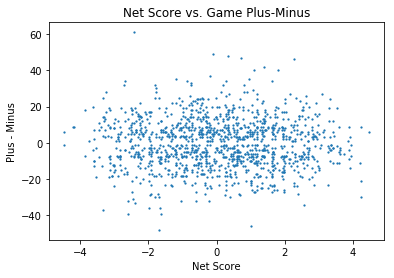

In [713]:
plt.figure(1)
plt.scatter(games['netScore'],games['PLUS_MINUS'],s = 1.5)
plt.title("Net Score vs. Game Plus-Minus")
plt.xlabel("Net Score")
plt.ylabel("Plus - Minus")

In [714]:
total = 0
correct = 0 
for index, row in games.iterrows():
    if row['W'] == 1 and row['netScore'] > 0:
        correct = correct + 1
        total = total + 1
    elif row['W'] == 0 and row['netScore'] < 0:
        correct = correct + 1
        total = total + 1
    elif row['W'] == 1 and row['netScore'] < 0:
        total = total + 1
    elif row['W'] == 0 and row['netScore'] > 0:
        total = total + 1
print(correct)
print(total)
print(correct/total)

595
1230
0.483739837398374


In [715]:
stand = leaguestandings.LeagueStandings(season = '2014-15').get_data_frames()[0]
#print(list(stand.columns))
nba_teams = teams.get_teams()

lookup = {}
for team in nba_teams:
    teamid = team['id']
    lookup[team['nickname']] = team['abbreviation']

for index, row in stand.iterrows():
    name = row['TeamName']
    if name == 'Bobcats':
        abbrev = 'CHA'
    if name == 'SuperSonics':
        abbrev = 'OKC'
    else:
        abbrev = lookup[name]
    stand.at[index,'score'] = teamRank[abbrev]

#print(stand['WINS'])
stand.head()

,LeagueID,SeasonID,TeamID,TeamCity,TeamName,Conference,ConferenceRecord,PlayoffRank,ClinchIndicator,Division,...,Jun,Jul,Aug,Sep,Oct,Nov,Dec,PreAS,PostAS,score
0,00,22014,1610612737,Atlanta,Hawks,East,38-14,1,- e,Southeast,...,None,None,None,None,0-1,9-5,14-2,43-11,17-11,11.543515
1,00,22014,1610612744,Golden State,Warriors,West,42-10,1,- w,Pacific,...,None,None,None,None,1-0,13-2,11-3,42-9,25-6,9.365801
2,00,22014,1610612739,Cleveland,Cavaliers,East,35-17,2,- c,Central,...,None,None,None,None,1-1,7-6,10-7,33-22,20-7,9.060990
3,00,22014,1610612745,Houston,Rockets,West,33-19,2,- sw,Southwest,...,None,None,None,None,2-0,11-4,9-5,36-17,20-9,10.096877
4,00,22014,1610612741,Chicago,Bulls,East,33-19,3,- x,Central,...,None,None,None,None,1-1,10-5,11-4,34-20,16-12,9.479694


In [716]:
model2 = sm.OLS(stand['WINS'],stand['score']).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   WINS   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     271.6
Date:                Mon, 25 Feb 2019   Prob (F-statistic):           2.90e-16
Time:                        03:07:07   Log-Likelihood:                -120.38
No. Observations:                  30   AIC:                             242.8
Df Residuals:                      29   BIC:                             244.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
score          3.8375      0.233     16.480      0.000       3.361       4.314
==============================================================================
Omnibus:                        0.108   Durbin-Watson:                   0.429
Prob(Omnibus):                  0.948   Jarque-Bera (JB):                0.116
Skew:                          -0.104   Prob(JB):                        0.944
Kurtosis:                       2.777   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Wins')

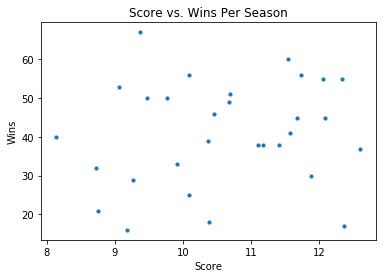

In [717]:
plt.figure(1)
plt.scatter(stand['score'],stand['WINS'],s = 10)
plt.title("Score vs. Wins Per Season")
plt.xlabel("Score")
plt.ylabel("Wins")

In [718]:
#What to do 

#Look at All-Star break before and after
#Fix Score
#Categorize scores into offensive, defensive, and attributes

#Work on actual calcuations
#What to do from here? Are we happy with this? 
#Potentially add in clutch player 

#Beginning season prediction - player stats from year before and lineups from this year
#All star break predictions
#Actual what happened

#Look at N-Max for 1,2,3,4,5 - Done results are alright



In [719]:
for k,v in teamRank.items():
    #print(k)
    print(v)

11.543514591231334
8.141085135055912
9.060990008991432
11.67296925902408
9.479694205496218
9.770195080008383
11.88282860828431
9.365801074746836
10.096876571310847
11.743723914617298
8.747865464628427
12.606767773080472
11.57998704758378
9.185701505035553
11.414027834669387
12.367939258465668
10.095109471787193
11.101627267195314
10.385075569785936
10.366791986558724
10.688142293605488
9.260948677477717
12.066930452390174
12.085464471802627
10.675510215667675
11.181469743438507
12.337108437990116
10.451694748506553
8.731142317800765
9.913017013763302


In [720]:
12.499515474567378
12.606767773080472
12.94911068

12.94911068